# Parallelization of Non-Negative Matrix Factorization with CUDA

Non-Negative matrix factorization (NMF) is an unsupervised machine learning technique often used in recommendation systems. A typical input is a large matrix of users and items, where rows represent user ratings for each item. NMF attempts to factor this large input matrix into two smaller matrices which can be used to recommend items to a user. In this project we investigate two multiplicative update rules for solving NMF as an optimization problem: Euclidean Distance and Kullback-Leibler Divergence. We first implement a serial Python approach of both algorithms in Python, and verify that they monotonically converge to a local minima. Then we implement a parallel approach in pyCUDA, and achieve identical results with a significant speed reduction for large inputs.

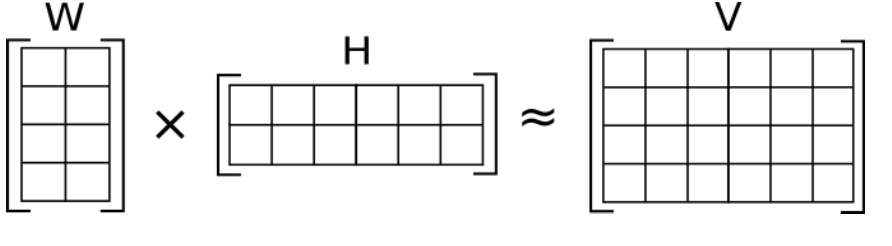

## Import Modules

In [2]:
import time
import numpy as np

from src.data_utils import get_matrices, get_topics, plot_execution_times, get_n_matrices, plot_loss
from src.nmf import NMF_serial, NMF_parallel, NMF_sklearn

# reload modules every 2 seconds (to see changes)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset

In [3]:
# define number of topics to extract from data
num_topics = 25

# define X, W, H matrices
X, W, H = get_matrices(num_topics)

print("X: ", X.shape, ": number of articles = {}, number of unique words = {}".format(X.shape[0], X.shape[1]))
print("W: ", W.shape, ": number of articles = {}, number of topics = {}".format(W.shape[0], W.shape[1]))
print("H: ", H.shape, ": number of topics = {}, number of unique words = {}".format(H.shape[0], H.shape[1]))


X:  (3012, 8447) : number of articles = 3012, number of unique words = 8447
W:  (3012, 25) : number of articles = 3012, number of topics = 25
H:  (25, 8447) : number of topics = 25, number of unique words = 8447


## NMF with Euclidean Multiplicative Updates

The Euclidean Distance cost function is

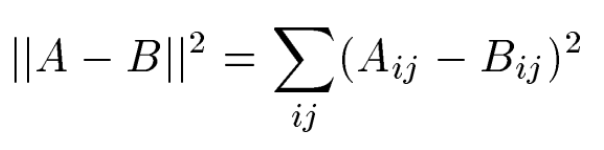

which corresponds to the update equations:

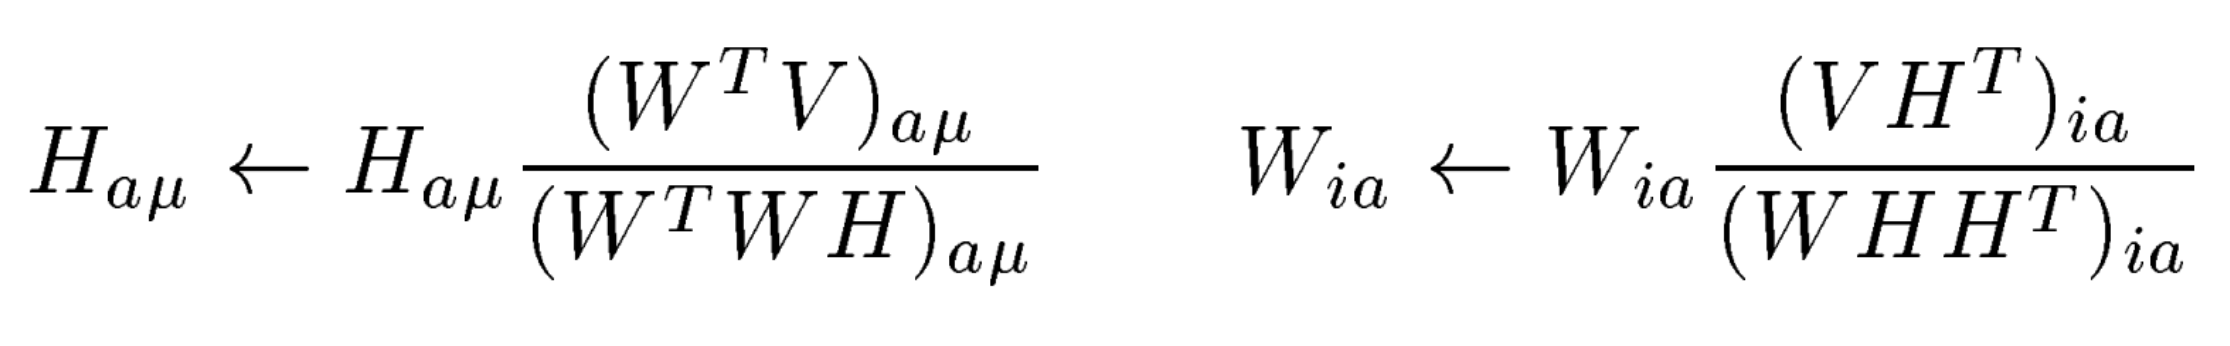

### Serial Euclidean NMF with Python

In [4]:
num_iterations = 100
W_serial, H_serial, losses_serial, time_serial = NMF_serial(X, W, H)

print("{} iterations of serial Euclidean NMF completed in {} s.".format(num_iterations, round(time_serial, 3)))

Starting 100 iterations of serial NMF with euclidean loss.
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
100 iterations of serial Euclidean NMF completed in 45.115 s.


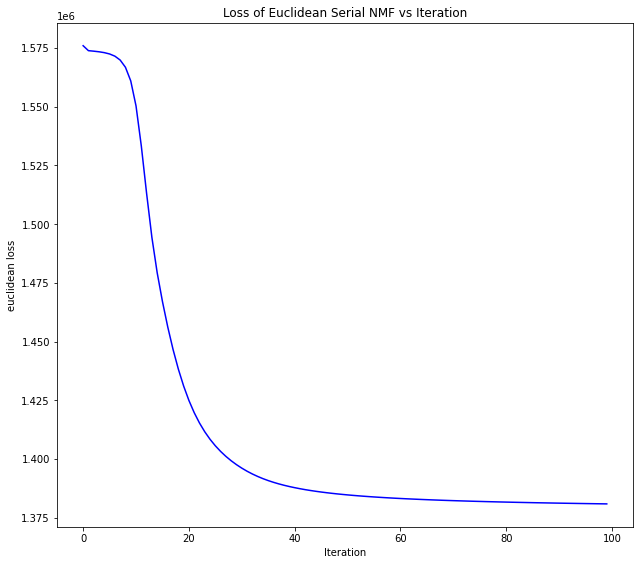

In [5]:
# visualize loss 
title = "Loss of Euclidean Serial NMF vs Iteration"
plot_loss(losses_serial, title)

In [6]:
# Visualize results
get_topics(W_serial, print_results=False) # NOTE: change W_serial --> W to see initial topics

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,...,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25
0,0.0240 percent,0.0623 states,0.0198 campaign,0.0421 father,0.0098 mile,0.0195 official,0.0263 pay,0.0146 company,0.0239 music,0.0202 second,...,0.0129 art,0.0107 serve,0.0161 question,0.0218 film,0.0192 building,0.0402 company,0.0194 thing,0.0282 case,0.0245 play,0.0129 public
1,0.0197 rate,0.0546 american,0.0180 vote,0.0382 graduate,0.0078 water,0.0134 force,0.0194 member,0.0137 computer,0.0128 performance,0.0201 hit,...,0.0097 artist,0.0097 add,0.0121 ask,0.0175 movie,0.0185 city,0.0296 executive,0.0138 tell,0.0218 court,0.0241 team,0.0093 change
2,0.0159 increase,0.0426 country,0.0179 political,0.0294 son,0.0075 hour,0.0132 military,0.0159 worker,0.0111 system,0.0126 play,0.0169 third,...,0.0077 exhibition,0.0091 minute,0.0102 report,0.0168 play,0.0131 house,0.0217 president,0.0133 ask,0.0214 lawyer,0.0240 game,0.0091 issue
3,0.0155 rise,0.0236 world,0.0175 party,0.0293 school,0.0073 car,0.0131 government,0.0159 money,0.0097 service,0.0111 perform,0.0149 start,...,0.0070 painting,0.0088 pepper,0.0093 issue,0.0140 television,0.0131 build,0.0204 business,0.0118 lot,0.0172 law,0.0190 player,0.0084 power
4,0.0133 economy,0.0150 americans,0.0168 election,0.0279 mrs,0.0068 place,0.0111 leader,0.0144 job,0.0096 technology,0.0105 song,0.0140 win,...,0.0064 museum,0.0087 food,0.0078 write,0.0120 director,0.0120 area,0.0191 chief,0.0114 feel,0.0144 state,0.0164 season,0.0078 policy
5,0.0123 report,0.0135 international,0.0164 republican,0.0261 daughter,0.0063 drive,0.0104 war,0.0136 union,0.0087 sell,0.0100 concert,0.0136 game,...,0.0061 collection,0.0084 oil,0.0077 tell,0.0118 character,0.0104 home,0.0138 chairman,0.0093 really,0.0143 judge,0.0140 point,0.0069 political
6,0.0113 low,0.0133 foreign,0.0163 candidate,0.0244 mother,0.0057 line,0.0083 troop,0.0119 law,0.0078 customer,0.0095 dance,0.0131 inning,...,0.0057 early,0.0083 cook,0.0071 interview,0.0103 production,0.0099 community,0.0112 vice,0.0090 start,0.0137 charge,0.0135 win,0.0062 problem
7,0.0111 economic,0.0098 nation,0.0144 democratic,0.0214 student,0.0056 foot,0.0076 peace,0.0116 service,0.0077 information,0.0093 night,0.0123 pitch,...,0.0055 form,0.0082 cup,0.0064 meeting,0.0097 star,0.0096 live,0.0104 industry,0.0086 put,0.0115 trial,0.0116 coach,0.0057 system
8,0.0102 growth,0.0098 european,0.0135 leader,0.0201 receive,0.0055 area,0.0074 attack,0.0114 official,0.0076 offer,0.0092 program,0.0123 home,...,0.0055 design,0.0080 sauce,0.0064 add,0.0091 actor,0.0096 resident,0.0093 large,0.0083 little,0.0108 legal,0.0097 second,0.0056 believe
9,0.0085 decline,0.0093 trade,0.0134 voter,0.0196 marry,0.0053 road,0.0070 agreement,0.0112 bill,0.0073 product,0.0084 sound,0.0116 victory,...,0.0054 view,0.0076 taste,0.0060 member,0.0085 direct,0.0092 site,0.0089 director,0.0082 keep,0.0094 file,0.0088 victory,0.0047 view


### Serial Euclidean NMF with Scikit-Learn

In [7]:
W_sklearn, H_sklearn, time_sklearn = NMF_sklearn(X, W, H, iterations=num_iterations, loss='euclidean')

print("{} iterations of sklearn Euclidean NMF completed in {} s.".format(num_iterations, round(time_sklearn, 3)))


Starting 100 iterations of Scikit-learn NMF with euclidean loss.


/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


100 iterations of sklearn Euclidean NMF completed in 8.071 s.


In [8]:
# Visualize results
get_topics(W_sklearn, print_results=False)

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,...,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25
0,0.0287 percent,0.0534 states,0.0183 campaign,0.0413 father,0.0085 mile,0.0179 official,0.0264 official,0.0271 company,0.0238 music,0.0195 hit,...,0.0122 art,0.0108 serve,0.0160 question,0.0199 film,0.0204 building,0.0336 company,0.0199 thing,0.0268 case,0.0229 play,0.0237 public
1,0.0182 rate,0.0450 american,0.0178 political,0.0377 graduate,0.0078 hour,0.0139 force,0.0255 member,0.0139 computer,0.0130 performance,0.0170 second,...,0.0092 artist,0.0100 add,0.0137 ask,0.0165 play,0.0182 city,0.0300 executive,0.0147 home,0.0208 court,0.0227 game,0.0124 issue
2,0.0177 rise,0.0392 country,0.0172 vote,0.0326 school,0.0072 car,0.0136 military,0.0222 job,0.0105 technology,0.0126 play,0.0151 game,...,0.0072 exhibition,0.0091 minute,0.0095 tell,0.0163 movie,0.0141 build,0.0214 president,0.0132 lot,0.0205 lawyer,0.0221 team,0.0104 problem
3,0.0143 market,0.0228 world,0.0161 party,0.0285 son,0.0063 water,0.0122 government,0.0202 worker,0.0105 industry,0.0111 perform,0.0149 third,...,0.0067 painting,0.0090 pepper,0.0081 issue,0.0131 television,0.0133 area,0.0206 chief,0.0120 tell,0.0177 law,0.0176 player,0.0101 policy
4,0.0131 increase,0.0131 americans,0.0156 election,0.0266 mrs,0.0062 place,0.0111 war,0.0200 city,0.0102 product,0.0104 song,0.0146 start,...,0.0058 museum,0.0087 food,0.0069 meeting,0.0109 director,0.0120 house,0.0164 business,0.0112 feel,0.0137 state,0.0151 season,0.0097 system
5,0.0124 fall,0.0124 foreign,0.0151 republican,0.0256 daughter,0.0061 line,0.0104 leader,0.0179 pay,0.0098 system,0.0100 concert,0.0135 inning,...,0.0058 collection,0.0086 oil,0.0064 answer,0.0108 character,0.0100 project,0.0154 chairman,0.0110 ask,0.0136 judge,0.0142 win,0.0093 change
6,0.0118 price,0.0118 international,0.0150 candidate,0.0249 student,0.0060 drive,0.0084 troop,0.0168 union,0.0093 service,0.0097 program,0.0128 pitch,...,0.0057 early,0.0084 cook,0.0063 interview,0.0095 star,0.0098 site,0.0112 vice,0.0105 live,0.0133 charge,0.0135 point,0.0079 power
7,0.0115 report,0.0110 nation,0.0134 democratic,0.0242 mother,0.0056 stop,0.0075 attack,0.0139 service,0.0091 business,0.0096 dance,0.0121 season,...,0.0056 form,0.0083 cup,0.0061 write,0.0091 production,0.0098 resident,0.0109 yesterday,0.0102 keep,0.0107 trial,0.0111 coach,0.0064 concern
8,0.0113 low,0.0088 government,0.0127 leader,0.0192 receive,0.0052 foot,0.0074 peace,0.0116 group,0.0086 customer,0.0092 night,0.0119 win,...,0.0054 view,0.0081 sauce,0.0058 point,0.0084 actor,0.0093 community,0.0100 financial,0.0092 put,0.0104 legal,0.0111 second,0.0061 action
9,0.0109 economy,0.0088 european,0.0125 state,0.0190 marry,0.0049 trip,0.0066 nations,0.0113 employee,0.0076 sell,0.0081 sound,0.0112 home,...,0.0054 image,0.0077 taste,0.0055 add,0.0077 audience,0.0093 open,0.0099 share,0.0092 really,0.0092 file,0.0095 victory,0.0058 political


### Parallel Euclidean NMF with CUDA

In [9]:
W_parallel, H_parallel, time_parallel = NMF_parallel(X, W, H)

print("{} iterations of parallel Euclidean NMF completed in {} s.".format(num_iterations, round(time_parallel, 3)))

Starting 100 iterations of parallel NMF with euclidean multiplicative updates.
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
100 iterations of parallel Euclidean NMF completed in 1.12 s.


In [10]:
# Visualize results
get_topics(W_parallel, print_results=False)

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,...,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25
0,0.0331 percent,0.0543 states,0.0185 campaign,0.0499 school,0.0086 hour,0.0157 official,0.0390 official,0.0195 company,0.0244 music,0.0226 second,...,0.0133 art,0.0108 serve,0.0145 question,0.0227 film,0.0196 building,0.0353 company,0.0237 thing,0.0276 case,0.0257 team,0.0156 public
1,0.0188 rate,0.0427 american,0.0184 political,0.0383 student,0.0082 mile,0.0140 force,0.0266 city,0.0143 computer,0.0128 performance,0.0207 hit,...,0.0100 artist,0.0100 add,0.0142 ask,0.0183 play,0.0155 city,0.0337 executive,0.0142 lot,0.0216 court,0.0251 play,0.0112 issue
2,0.0181 rise,0.0416 country,0.0169 vote,0.0224 child,0.0076 car,0.0140 military,0.0260 member,0.0109 system,0.0124 play,0.0182 third,...,0.0080 exhibition,0.0091 minute,0.0109 tell,0.0181 movie,0.0145 build,0.0286 president,0.0130 feel,0.0214 lawyer,0.0249 game,0.0106 change
3,0.0140 increase,0.0233 world,0.0165 party,0.0205 graduate,0.0064 line,0.0120 government,0.0191 job,0.0104 service,0.0115 perform,0.0148 win,...,0.0072 painting,0.0090 pepper,0.0071 meeting,0.0139 television,0.0139 area,0.0229 chief,0.0113 put,0.0191 law,0.0203 player,0.0097 problem
4,0.0126 market,0.0132 foreign,0.0157 election,0.0169 education,0.0061 drive,0.0116 war,0.0182 worker,0.0103 technology,0.0107 song,0.0146 start,...,0.0067 museum,0.0087 food,0.0068 issue,0.0126 director,0.0133 house,0.0166 chairman,0.0110 tell,0.0141 judge,0.0175 season,0.0086 system
5,0.0124 price,0.0123 americans,0.0154 candidate,0.0167 parent,0.0059 stop,0.0105 leader,0.0180 group,0.0085 industry,0.0102 concert,0.0138 game,...,0.0062 collection,0.0087 oil,0.0068 write,0.0126 character,0.0111 home,0.0151 vice,0.0108 really,0.0134 charge,0.0138 point,0.0071 policy
6,0.0123 fall,0.0120 international,0.0151 republican,0.0166 father,0.0058 place,0.0085 troop,0.0154 union,0.0083 product,0.0096 dance,0.0131 home,...,0.0058 early,0.0085 cook,0.0065 interview,0.0109 production,0.0104 resident,0.0149 business,0.0107 little,0.0128 state,0.0136 win,0.0066 power
7,0.0123 report,0.0118 government,0.0135 democratic,0.0163 teacher,0.0056 water,0.0076 attack,0.0136 service,0.0082 customer,0.0093 night,0.0130 inning,...,0.0056 design,0.0084 cup,0.0061 answer,0.0100 star,0.0101 project,0.0136 yesterday,0.0106 start,0.0110 trial,0.0123 coach,0.0050 concern
8,0.0122 low,0.0116 nation,0.0125 voter,0.0151 college,0.0054 night,0.0075 peace,0.0127 pay,0.0076 information,0.0090 program,0.0129 victory,...,0.0056 view,0.0081 sauce,0.0059 speak,0.0096 actor,0.0098 live,0.0117 director,0.0101 keep,0.0110 legal,0.0088 second,0.0048 action
9,0.0109 point,0.0097 economic,0.0125 leader,0.0134 class,0.0054 trip,0.0066 nations,0.0102 employee,0.0071 sell,0.0085 sound,0.0126 score,...,0.0055 form,0.0077 taste,0.0057 meet,0.0090 direct,0.0096 site,0.0104 announce,0.0101 ask,0.0094 file,0.0084 victory,0.0048 require


### Visualize Execution Time Differences

In [11]:
# input_sizes = [10**i for i in range(1, 5)] # define range of input sizes
input_sizes = [10**i for i in range(1, 4)] # define range of input sizes


K = 25 # define learnable dimension size parameter

execution_times_parallel = [] # initialize execution time lists
execution_times_serial = []
execution_times_sklearn = []

for input_size in input_sizes: # iterate over input sizes
    input_shape = (input_size, input_size)
    X, W, H = get_n_matrices(K, input_shape) # generate random X, W, H matrices of size input_shape
    W_p, H_p, ex_time_parallel = NMF_parallel(X, W, H, print_iterations=False) # call parallel NMF
    W_s, H_s, _, ex_time_serial = NMF_serial(X, W, H, print_iterations=False) # call sequential NMF
    W_sk, H_sk, ex_time_sklearn = NMF_sklearn(X, W, H) # call sklearn NMF
    

    execution_times_parallel.append(ex_time_parallel) # store execution times
    execution_times_serial.append(ex_time_serial)
    execution_times_sklearn.append(ex_time_sklearn)    

Starting 100 iterations of parallel NMF with euclidean multiplicative updates.
Starting 100 iterations of serial NMF with euclidean loss.
Starting 100 iterations of Scikit-learn NMF with euclidean loss.
Starting 100 iterations of parallel NMF with euclidean multiplicative updates.
Starting 100 iterations of serial NMF with euclidean loss.
Starting 100 iterations of Scikit-learn NMF with euclidean loss.
Starting 100 iterations of parallel NMF with euclidean multiplicative updates.


/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Starting 100 iterations of serial NMF with euclidean loss.
Starting 100 iterations of Scikit-learn NMF with euclidean loss.


/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


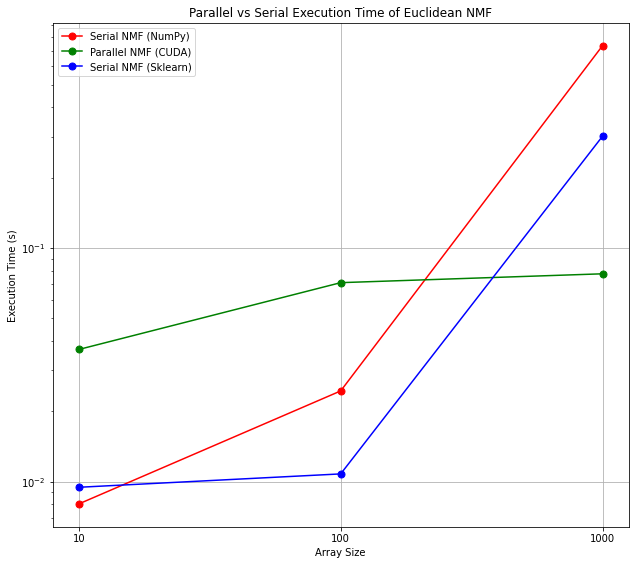

In [12]:
title = "Parallel vs Serial Execution Time of Euclidean NMF" # define plot title

# generate plot
plot_execution_times(execution_times_parallel,  
                     execution_times_serial, 
                     execution_times_sklearn, 
                     title,
                     input_sizes)

## NMF with KL Divergence Multiplicative Updates

The KL Divergence cost function is

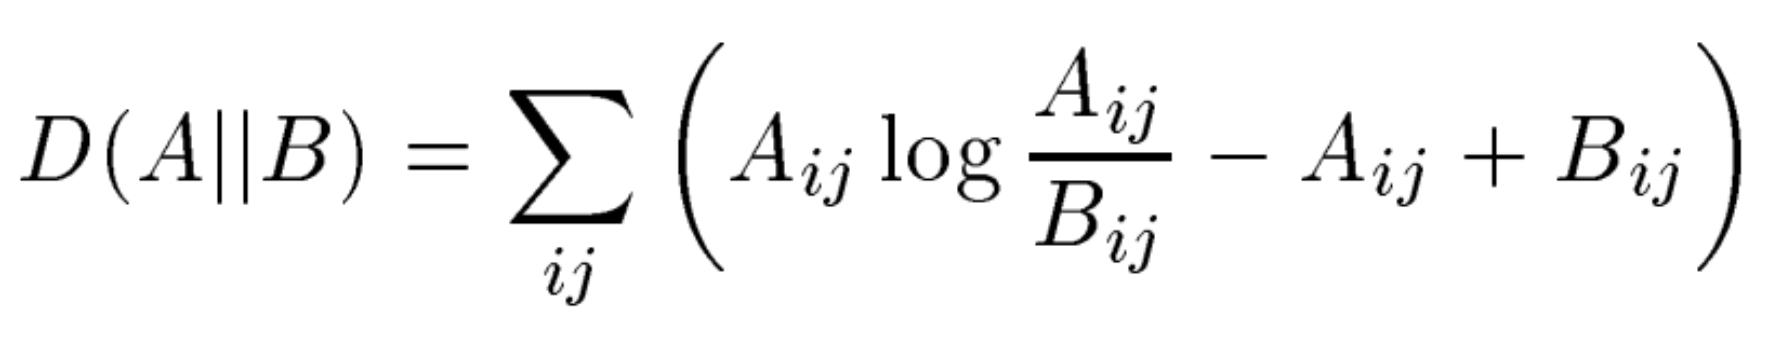

which corresponds to the update equations:

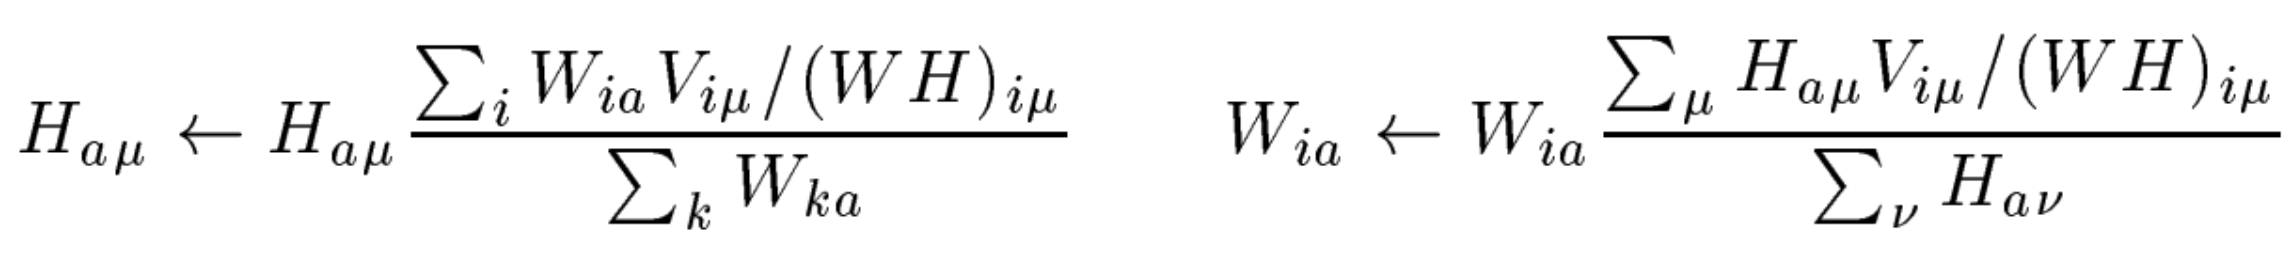

### Serial KL Divergence NMF with Python

In [13]:
# define number of topics to extract from data
num_topics = 25

# define X, W, H matrices
X, W, H = get_matrices(num_topics)

W_serial_kl, H_serial_kl, losses_serial_kl, time_serial_kl = NMF_serial(X, W, H, loss='divergence')

print("{} iterations of serial KL Divergence NMF completed in {} s.".format(num_iterations, round(time_serial_kl, 3)))

Starting 100 iterations of serial NMF with divergence loss.
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
100 iterations of serial KL Divergence NMF completed in 123.021 s.


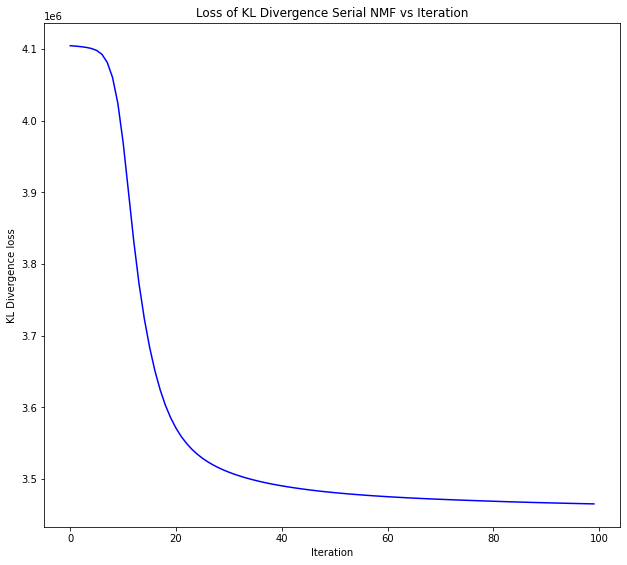

In [14]:
# visualize loss
title = "Loss of KL Divergence Serial NMF vs Iteration"
plot_loss(losses_serial_kl, title, loss_type='KL Divergence')

In [15]:
# Visualize results
get_topics(W_serial_kl, print_results=False)

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,...,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25
0,0.0243 sell,0.0308 school,0.0311 police,0.0557 father,0.0115 cause,0.0157 official,0.0163 pay,0.0206 food,0.0231 music,0.0371 team,...,0.0204 art,0.0123 design,0.0197 country,0.0182 television,0.0155 mile,0.0393 company,0.0178 thing,0.0179 case,0.0241 win,0.0212 campaign
1,0.0203 sale,0.0259 student,0.0191 kill,0.0465 son,0.0098 problem,0.0120 military,0.0154 money,0.0113 fresh,0.0197 play,0.0249 player,...,0.0126 artist,0.0100 color,0.0164 government,0.0069 network,0.0118 travel,0.0212 executive,0.0133 feel,0.0157 court,0.0208 second,0.0171 vote
2,0.0184 company,0.0122 child,0.0183 officer,0.0437 mrs,0.0090 damage,0.0118 american,0.0138 state,0.0108 serve,0.0149 performance,0.0244 season,...,0.0093 history,0.0095 wall,0.0160 political,0.0068 video,0.0106 hour,0.0154 business,0.0130 ask,0.0155 lawyer,0.0166 play,0.0144 political
3,0.0179 store,0.0118 program,0.0158 man,0.0386 mother,0.0073 plant,0.0109 states,0.0128 budget,0.0098 pound,0.0101 perform,0.0237 game,...,0.0090 century,0.0091 display,0.0112 american,0.0066 medium,0.0106 town,0.0145 president,0.0126 lot,0.0140 law,0.0164 game,0.0142 election
4,0.0173 buy,0.0118 class,0.0153 charge,0.0362 daughter,0.0073 water,0.0094 war,0.0128 bill,0.0096 eat,0.0100 stage,0.0192 play,...,0.0080 image,0.0071 room,0.0108 policy,0.0063 computer,0.0104 car,0.0131 chief,0.0114 tell,0.0111 judge,0.0152 victory,0.0141 candidate
5,0.0130 price,0.0109 education,0.0135 crime,0.0286 graduate,0.0070 official,0.0087 force,0.0109 tax,0.0090 restaurant,0.0099 production,0.0159 coach,...,0.0072 american,0.0065 small,0.0105 states,0.0061 program,0.0099 city,0.0109 share,0.0110 really,0.0097 legal,0.0137 score,0.0136 party
6,0.0121 business,0.0108 college,0.0131 arrest,0.0260 family,0.0066 report,0.0080 meeting,0.0102 program,0.0088 taste,0.0099 theater,0.0123 baseball,...,0.0071 culture,0.0064 glass,0.0104 nation,0.0060 movie,0.0094 trip,0.0101 chairman,0.0093 little,0.0087 issue,0.0132 third,0.0131 republican
7,0.0108 cost,0.0093 group,0.0123 death,0.0246 marry,0.0057 scientist,0.0078 government,0.0098 cut,0.0086 dry,0.0099 dance,0.0115 league,...,0.0070 world,0.0064 light,0.0103 leader,0.0059 screen,0.0087 road,0.0087 yesterday,0.0090 happen,0.0080 rule,0.0123 point,0.0103 democratic
8,0.0107 industry,0.0089 teacher,0.0117 official,0.0206 receive,0.0055 safety,0.0069 nations,0.0095 plan,0.0083 cook,0.0095 song,0.0094 contract,...,0.0070 exhibition,0.0064 red,0.0100 power,0.0058 create,0.0086 train,0.0087 announce,0.0087 put,0.0077 charge,0.0104 lose,0.0091 voter
9,0.0105 customer,0.0088 community,0.0102 victim,0.0205 retire,0.0054 system,0.0069 agreement,0.0092 cost,0.0082 fish,0.0095 audience,0.0092 football,...,0.0069 photograph,0.0062 open,0.0088 economic,0.0056 different,0.0084 drive,0.0086 financial,0.0082 keep,0.0076 state,0.0101 final,0.0091 support


### Serial KL Divergence NMF with Scikit-Learn

In [16]:
W_sklearn_kl, H_sklearn_kl, time_sklearn_kl = NMF_sklearn(X, W, H, iterations=num_iterations, loss='divergence')

print("{} iterations of sklearn KL Divergence NMF completed in {} s.".format(num_iterations, round(time_sklearn_kl, 3)))


Starting 100 iterations of Scikit-learn NMF with divergence loss.


/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


100 iterations of sklearn KL Divergence NMF completed in 45.128 s.


In [17]:
# Visualize results
get_topics(W_sklearn_kl, print_results=False)

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,...,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25
0,0.0306 percent,0.0316 school,0.0277 police,0.0534 father,0.0266 report,0.0161 military,0.0179 pay,0.0117 water,0.0201 play,0.0388 team,...,0.0172 music,0.0154 food,0.0187 political,0.0110 thing,0.0123 city,0.0368 company,0.0149 wait,0.0172 case,0.0271 win,0.0201 states
1,0.0187 price,0.0264 student,0.0194 charge,0.0445 son,0.0137 official,0.0143 war,0.0164 money,0.0117 plant,0.0158 thing,0.0277 season,...,0.0133 art,0.0096 serve,0.0184 campaign,0.0085 great,0.0121 town,0.0207 executive,0.0135 ask,0.0154 court,0.0235 second,0.0181 american
2,0.0181 rate,0.0120 class,0.0153 officer,0.0419 mrs,0.0109 appear,0.0123 government,0.0146 state,0.0088 air,0.0119 lot,0.0274 game,...,0.0109 play,0.0093 restaurant,0.0183 vote,0.0081 question,0.0114 visit,0.0174 business,0.0131 tell,0.0152 law,0.0164 victory,0.0153 country
3,0.0179 market,0.0118 child,0.0150 man,0.0397 mother,0.0106 number,0.0113 force,0.0130 budget,0.0083 plane,0.0109 guy,0.0239 player,...,0.0096 artist,0.0090 fresh,0.0138 party,0.0078 mean,0.0090 mile,0.0138 president,0.0127 walk,0.0141 lawyer,0.0164 score,0.0151 policy
4,0.0152 rise,0.0114 education,0.0124 crime,0.0347 daughter,0.0106 problem,0.0109 leader,0.0115 bill,0.0083 car,0.0106 young,0.0169 coach,...,0.0093 performance,0.0084 taste,0.0135 election,0.0077 put,0.0089 home,0.0124 chief,0.0114 start,0.0110 legal,0.0162 play,0.0125 editor
5,0.0114 economy,0.0111 program,0.0120 arrest,0.0273 graduate,0.0097 condition,0.0088 american,0.0113 tax,0.0081 flight,0.0105 tell,0.0167 play,...,0.0076 director,0.0079 dry,0.0133 candidate,0.0073 far,0.0086 live,0.0122 share,0.0107 feel,0.0109 rule,0.0150 game,0.0115 government
6,0.0109 increase,0.0106 college,0.0108 official,0.0259 family,0.0095 release,0.0087 official,0.0107 cost,0.0076 gas,0.0087 really,0.0127 league,...,0.0076 theater,0.0074 dinner,0.0132 republican,0.0072 point,0.0084 local,0.0100 sell,0.0100 decide,0.0107 judge,0.0148 third,0.0101 official
7,0.0103 low,0.0105 group,0.0101 criminal,0.0236 marry,0.0095 accord,0.0085 peace,0.0105 program,0.0070 vehicle,0.0087 watch,0.0126 baseball,...,0.0075 stage,0.0073 eat,0.0124 leader,0.0067 kind,0.0082 travel,0.0096 chairman,0.0090 thing,0.0099 issue,0.0139 point,0.0091 nation
8,0.0100 fall,0.0094 community,0.0100 kill,0.0197 retire,0.0092 continue,0.0079 country,0.0103 cut,0.0070 cause,0.0086 little,0.0094 football,...,0.0074 production,0.0072 cook,0.0109 democratic,0.0066 certainly,0.0078 car,0.0092 financial,0.0087 stay,0.0094 decision,0.0121 final,0.0086 foreign
9,0.0092 growth,0.0094 teacher,0.0094 yesterday,0.0195 receive,0.0092 occur,0.0073 nations,0.0102 plan,0.0069 safety,0.0085 hear,0.0089 contract,...,0.0073 audience,0.0071 add,0.0099 support,0.0066 different,0.0076 hour,0.0088 firm,0.0086 job,0.0088 state,0.0111 lose,0.0082 threat


### Parallel KL Divergence NMF with CUDA

In [18]:
W_parallel_kl, H_parallel_kl, time_parallel_kl = NMF_parallel(X, W, H, loss='divergence')

print("{} iterations of parallel Euclidean NMF completed in {} s.".format(num_iterations, round(time_parallel_kl, 3)))

Starting 100 iterations of parallel NMF with divergence multiplicative updates.
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
100 iterations of parallel Euclidean NMF completed in 1.555 s.


In [19]:
# Visualize results
get_topics(W_parallel_kl, print_results=False)

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,...,Topic_16,Topic_17,Topic_18,Topic_19,Topic_20,Topic_21,Topic_22,Topic_23,Topic_24,Topic_25
0,0.0313 percent,0.0374 school,0.0301 police,0.0562 father,0.0283 report,0.0174 military,0.0175 pay,0.0118 water,0.0151 thing,0.0354 team,...,0.0195 music,0.0164 food,0.0190 vote,0.0085 thing,0.0120 city,0.0388 company,0.0146 wait,0.0179 case,0.0275 win,0.0265 states
1,0.0188 price,0.0283 student,0.0195 charge,0.0469 son,0.0226 official,0.0152 war,0.0167 money,0.0117 plant,0.0113 tell,0.0283 game,...,0.0141 play,0.0098 restaurant,0.0189 campaign,0.0077 great,0.0109 town,0.0196 executive,0.0143 ask,0.0179 law,0.0221 second,0.0242 american
2,0.0186 rate,0.0139 child,0.0166 man,0.0442 mother,0.0109 news,0.0125 force,0.0146 state,0.0082 air,0.0107 young,0.0262 season,...,0.0110 performance,0.0097 serve,0.0188 political,0.0074 question,0.0104 visit,0.0178 business,0.0128 tell,0.0171 court,0.0159 play,0.0218 country
3,0.0175 market,0.0136 class,0.0162 officer,0.0441 mrs,0.0104 interview,0.0116 government,0.0131 budget,0.0081 cause,0.0107 play,0.0246 player,...,0.0095 art,0.0090 fresh,0.0140 party,0.0070 mean,0.0098 travel,0.0130 president,0.0119 feel,0.0156 lawyer,0.0157 victory,0.0147 government
4,0.0158 rise,0.0120 education,0.0141 crime,0.0365 daughter,0.0103 appear,0.0107 leader,0.0114 tax,0.0080 plane,0.0106 man,0.0188 play,...,0.0093 film,0.0089 taste,0.0137 election,0.0070 point,0.0098 mile,0.0127 share,0.0106 keep,0.0119 judge,0.0151 score,0.0138 policy
5,0.0110 increase,0.0118 program,0.0132 arrest,0.0286 graduate,0.0101 yesterday,0.0092 peace,0.0112 bill,0.0076 car,0.0098 lot,0.0160 coach,...,0.0088 production,0.0082 eat,0.0136 candidate,0.0068 far,0.0082 local,0.0121 chief,0.0102 decide,0.0117 legal,0.0141 third,0.0135 editor
6,0.0105 low,0.0116 college,0.0110 kill,0.0248 marry,0.0096 accord,0.0086 official,0.0111 cost,0.0073 gas,0.0087 watch,0.0120 baseball,...,0.0087 director,0.0078 dry,0.0136 republican,0.0066 different,0.0080 trip,0.0106 sell,0.0099 thing,0.0116 rule,0.0137 game,0.0117 nation
7,0.0105 fall,0.0107 group,0.0102 prison,0.0216 retire,0.0094 release,0.0082 attack,0.0107 program,0.0070 flight,0.0085 little,0.0118 league,...,0.0086 theater,0.0075 cook,0.0123 leader,0.0064 idea,0.0078 home,0.0098 financial,0.0098 start,0.0097 state,0.0133 point,0.0113 foreign
8,0.0100 economy,0.0102 teacher,0.0101 victim,0.0214 family,0.0091 spokesman,0.0079 nations,0.0105 plan,0.0066 damage,0.0084 love,0.0089 football,...,0.0086 audience,0.0073 dinner,0.0112 democratic,0.0063 view,0.0077 hour,0.0097 chairman,0.0096 put,0.0092 decision,0.0113 final,0.0105 world
9,0.0094 growth,0.0101 community,0.0097 prosecutor,0.0203 receive,0.0089 comment,0.0078 troop,0.0104 cut,0.0065 safety,0.0081 guy,0.0083 contract,...,0.0085 stage,0.0073 add,0.0101 support,0.0062 put,0.0076 street,0.0092 firm,0.0094 job,0.0092 issue,0.0111 lose,0.0098 international


## Visualize Time Differences

In [20]:
# input_sizes = [10**i for i in range(1, 5)] # define range of input sizes
input_sizes = [10**i for i in range(1, 4)] # define range of input sizes


K = 25 # define learnable dimension size parameter

execution_times_parallel = [] # initialize execution time lists
execution_times_serial = []
execution_times_sklearn = []

for input_size in input_sizes: # iterate over input sizes
    input_shape = (input_size, input_size)
    X, W, H = get_n_matrices(K, input_shape) # generate random X, W, H matrices of size input_shape
    W_p, H_p, ex_time_parallel = NMF_parallel(X, W, H, print_iterations=False, loss='divergence') # call parallel NMF
    W_s, H_s, _, ex_time_serial = NMF_serial(X, W, H, print_iterations=False, loss='divergence') # call sequential NMF
    W_sk, H_sk, ex_time_sklearn = NMF_sklearn(X, W, H, loss='divergence') # call sklearn NMF
    

    execution_times_parallel.append(ex_time_parallel) # store execution times
    execution_times_serial.append(ex_time_serial)
    execution_times_sklearn.append(ex_time_sklearn)    

Starting 100 iterations of parallel NMF with divergence multiplicative updates.
Starting 100 iterations of serial NMF with divergence loss.
Starting 100 iterations of Scikit-learn NMF with divergence loss.
Starting 100 iterations of parallel NMF with divergence multiplicative updates.
Starting 100 iterations of serial NMF with divergence loss.
Starting 100 iterations of Scikit-learn NMF with divergence loss.
Starting 100 iterations of parallel NMF with divergence multiplicative updates.


/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Starting 100 iterations of serial NMF with divergence loss.
Starting 100 iterations of Scikit-learn NMF with divergence loss.


/home/alexangus/envs/cudaEnv/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


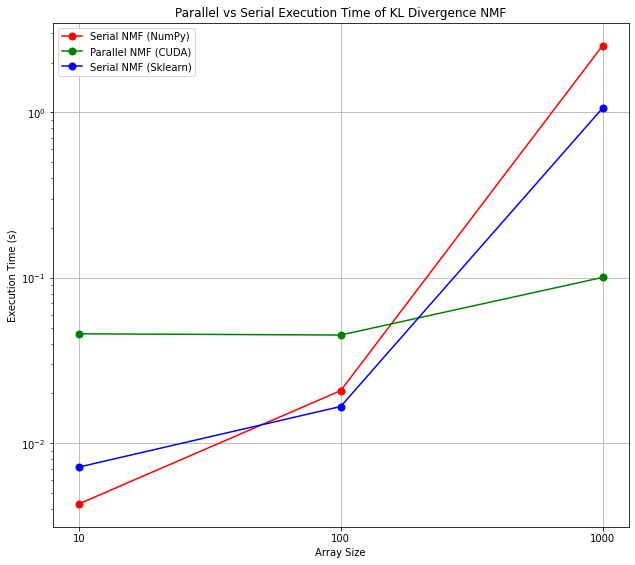

In [21]:
title = "Parallel vs Serial Execution Time of KL Divergence NMF" # define plot title

# generate plot
plot_execution_times(execution_times_parallel,  
                     execution_times_serial, 
                     execution_times_sklearn, 
                     title,
                     input_sizes)